In [ ]:
!pip -q install vk_api pymorphy3 nltk scikit-learn joblib tensorflow


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import numpy as np
import pandas as pd
import re
import time
import datetime as dt

import pymorphy3
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import PoissonRegressor


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

import joblib

nltk.download('punkt')
nltk.download('stopwords')
stopwords_ru = set(nltk.corpus.stopwords.words("russian"))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\miron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
token = 'vk1.a.F_N9-61GyWMP4kf8kOjf6nBqDumII-DMjsNmrcCfWkTbdXhym-WyF1y4Q6_-gCllwR0fKSNUn6n4vTNhCOEDDIzPY9tK5Z-Mf6-OnOGnimSAsg1eTJX3ldVHdkPu0CXpxDoZ7-cKWgWnbBKpS9ssUkQYtpYvZaEPdbLgkk5XGpG--HjhgP8peEqmfniJJNEhi9_HYYt_ahK7R6bXlFG72Q'  
group_ids = ['-187956888']

In [ ]:
import vk_api
import pandas as pd
import re

def main(offset: int, token: str, group_id: str):
    vk = vk_api.VkApi(token=token)
    api = vk.get_api()

    resp = api.wall.get(owner_id=int(group_id), offset=offset, count=100)
    posts = resp.get('items', [])

    posts_strings = []
    num_comments = []
    num_like = []
    views = []
    reposts = []
    dates = []

    for post in posts:
        posts_strings.append(post.get('text', ''))
        num_comments.append(int(post.get('comments', {}).get('count', 0)))
        num_like.append(int(post.get('likes', {}).get('count', 0)))
        views.append(int(post.get('views', {}).get('count', 0)) if isinstance(post.get('views', None), dict) else 0)
        reposts.append(int(post.get('reposts', {}).get('count', 0)))
        dates.append(int(post.get('date', 0)))

    return posts_strings, num_comments, num_like, views, reposts, dates

In [ ]:
combo_list_posts = []
combo_list_num_comments = []
combo_list_num_like = []
combo_list_views = []
combo_list_reposts = []
combo_list_dates = []
combo_list_group = []

POSTS_PER_GROUP = 3000
STEP = 100

for offset in range(0, POSTS_PER_GROUP, STEP):
    posts, ncomm, nlike, vws, rps, dts = main(offset, token, group_ids)
    combo_list_posts.extend(posts)
    combo_list_num_comments.extend(ncomm)
    combo_list_num_like.extend(nlike)
    combo_list_views.extend(vws)
    combo_list_reposts.extend(rps)
    combo_list_dates.extend(dts)
    combo_list_group.extend([group_id] * len(posts))

    print(f"  Offset {offset}: собрано {len(posts)} постов (итого {len(combo_list_posts)})")

print(f"\nВсего постов: {len(combo_list_posts)}")
print(f"Уникальных постов: {len(set(combo_list_posts))}")

Парсинг группы -187956888...
  Offset 0: собрано 100 постов (итого 100)
  Offset 100: собрано 100 постов (итого 200)
  Offset 200: собрано 100 постов (итого 300)
  Offset 300: собрано 100 постов (итого 400)
  Offset 400: собрано 100 постов (итого 500)
  Offset 500: собрано 100 постов (итого 600)
  Offset 600: собрано 100 постов (итого 700)
  Offset 700: собрано 100 постов (итого 800)
  Offset 800: собрано 100 постов (итого 900)
  Offset 900: собрано 100 постов (итого 1000)
  Offset 1000: собрано 100 постов (итого 1100)
  Offset 1100: собрано 100 постов (итого 1200)
  Offset 1200: собрано 100 постов (итого 1300)
  Offset 1300: собрано 100 постов (итого 1400)
  Offset 1400: собрано 100 постов (итого 1500)
  Offset 1500: собрано 100 постов (итого 1600)
  Offset 1600: собрано 100 постов (итого 1700)
  Offset 1700: собрано 100 постов (итого 1800)
  Offset 1800: собрано 100 постов (итого 1900)
  Offset 1900: собрано 100 постов (итого 2000)
  Offset 2000: собрано 100 постов (итого 2100)
  Off

In [ ]:
df_posts = pd.DataFrame({
    "group_id": combo_list_group,
    "text": combo_list_posts,
    "num_comments": combo_list_num_comments,
    "num_like": combo_list_num_like,
    "views": combo_list_views,
    "reposts": combo_list_reposts,
    "date_unix": combo_list_dates
})

df_posts["text"] = df_posts["text"].astype(str)
df_posts = df_posts[df_posts["text"].str.strip().str.len() > 0].copy()

df_posts.to_csv("vk_posts_transport_spb_fast.csv", index=False, encoding="utf-8-sig")
df_posts.head()

,group_id,text,num_comments,num_like,views,reposts,date_unix
0,-187956888,"Сегодня исполняется ровно 8 лет с момента, ког...",72,41,3139,0,1765536967
1,-187956888,Молодые специалисты транспортной отрасли Петер...,10,49,7602,5,1765533612
3,-187956888,Поздравляем с одним из самых значимых государс...,37,30,1655,3,1765519200
4,-187956888,Санкт-Петербург: от летней столицы к круглогод...,62,41,2391,2,1765456788
5,-187956888,Сегодня председатель Комитета по транспорту Ва...,85,77,9997,8,1765380229


In [ ]:
df_text = df_posts.copy()
df_text["process_texts"] = df_text["text"].astype(str)

print("Всего строк в таблице: ", df_text.shape[0])
print("Пропуски:\n", df_text.isna().sum())

df_text = df_text.dropna()
print("Всего строк без пропусков: ", df_text.shape[0])

duplicated_mask = df_text.duplicated(subset='process_texts', keep=False)
print(f'Всего {np.sum(duplicated_mask)} повторяющихся постов.\n')

df_text = df_text.drop_duplicates(subset='process_texts', keep='first')
print(f'Таблица без повторов: {df_text.shape[0]} строк.')

df_text = df_text[df_text["process_texts"].str.strip().str.len() > 0].copy()
print("После удаления пустых текстов:", df_text.shape[0])

df_text.head()

Всего строк в таблице:  2495
Пропуски:
 group_id         0
text             0
num_comments     0
num_like         0
views            0
reposts          0
date_unix        0
process_texts    0
dtype: int64
Всего строк без пропусков:  2495
Всего 4 повторяющихся постов.

Таблица без повторов: 2492 строк.
После удаления пустых текстов: 2492


,group_id,text,num_comments,num_like,views,reposts,date_unix,process_texts
0,-187956888,"Сегодня исполняется ровно 8 лет с момента, ког...",72,41,3139,0,1765536967,"Сегодня исполняется ровно 8 лет с момента, ког..."
1,-187956888,Молодые специалисты транспортной отрасли Петер...,10,49,7602,5,1765533612,Молодые специалисты транспортной отрасли Петер...
3,-187956888,Поздравляем с одним из самых значимых государс...,37,30,1655,3,1765519200,Поздравляем с одним из самых значимых государс...
4,-187956888,Санкт-Петербург: от летней столицы к круглогод...,62,41,2391,2,1765456788,Санкт-Петербург: от летней столицы к круглогод...
5,-187956888,Сегодня председатель Комитета по транспорту Ва...,85,77,9997,8,1765380229,Сегодня председатель Комитета по транспорту Ва...


In [ ]:
morph = pymorphy3.MorphAnalyzer()

_url_re = re.compile(r"(https?://\S+|www\.\S+)")
_tag_re = re.compile(r"(@\w+|#\w+)")
_nonword_re = re.compile(r"[^\w\s]+")

LEMMA_CACHE = {}

def lemmatize_word(w: str) -> str:
    if w in LEMMA_CACHE:
        return LEMMA_CACHE[w]
    lemma = morph.parse(w)[0].normal_form
    LEMMA_CACHE[w] = lemma
    return lemma

def preprocess_one(text: str, do_lemmatize: bool = True) -> str:
    text = str(text).lower()
    text = _url_re.sub(" ", text)
    text = _tag_re.sub(" ", text)
    text = _nonword_re.sub(" ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stopwords_ru]

    if do_lemmatize:
        tokens = [lemmatize_word(t) for t in tokens]

    return " ".join(tokens)

df_text["process_texts"] = df_text["process_texts"].apply(lambda x: preprocess_one(x, do_lemmatize=True))

df_text = df_text[df_text["process_texts"].str.len() > 0].copy()
df_text.head()

,group_id,text,num_comments,num_like,views,reposts,date_unix,process_texts
0,-187956888,"Сегодня исполняется ровно 8 лет с момента, ког...",72,41,3139,0,1765536967,сегодня исполняться ровно год момент санкт пет...
1,-187956888,Молодые специалисты транспортной отрасли Петер...,10,49,7602,5,1765533612,молодой специалист транспортный отрасль петерб...
3,-187956888,Поздравляем с одним из самых значимых государс...,37,30,1655,3,1765519200,поздравлять один самый значимый государственны...
4,-187956888,Санкт-Петербург: от летней столицы к круглогод...,62,41,2391,2,1765456788,санкт петербург летний столица круглогодичный ...
5,-187956888,Сегодня председатель Комитета по транспорту Ва...,85,77,9997,8,1765380229,сегодня председатель комитет транспорт валенти...


In [ ]:

df_text["dt"] = pd.to_datetime(df_text["date_unix"], unit="s", errors="coerce")
df_text["hour"] = df_text["dt"].dt.hour.fillna(0).astype(int)
df_text["dow"] = df_text["dt"].dt.dayofweek.fillna(0).astype(int)  
df_text["month"] = df_text["dt"].dt.month.fillna(1).astype(int)


df_text["char_len"] = df_text["process_texts"].str.len()
df_text["word_len"] = df_text["process_texts"].str.split().apply(len)


for col in ["num_like", "views", "reposts"]:
    df_text[f"log1p_{col}"] = np.log1p(df_text[col].astype(float))

df_text[["process_texts","num_comments","num_like","views","reposts","hour","dow","word_len"]].head()

,process_texts,num_comments,num_like,views,reposts,hour,dow,word_len
0,сегодня исполняться ровно год момент санкт пет...,72,41,3139,0,10,4,90
1,молодой специалист транспортный отрасль петерб...,10,49,7602,5,10,4,92
3,поздравлять один самый значимый государственны...,37,30,1655,3,6,4,90
4,санкт петербург летний столица круглогодичный ...,62,41,2391,2,12,3,231
5,сегодня председатель комитет транспорт валенти...,85,77,9997,8,15,2,96


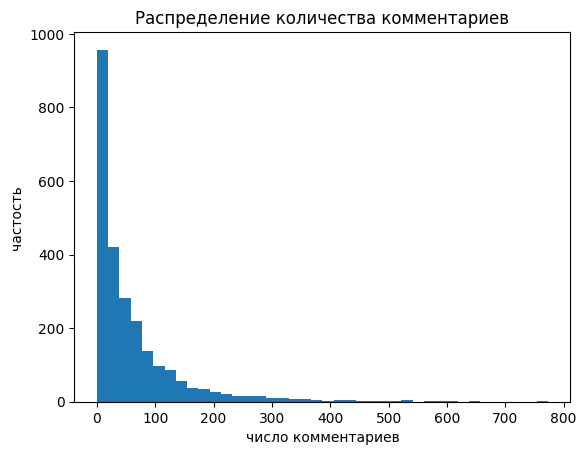

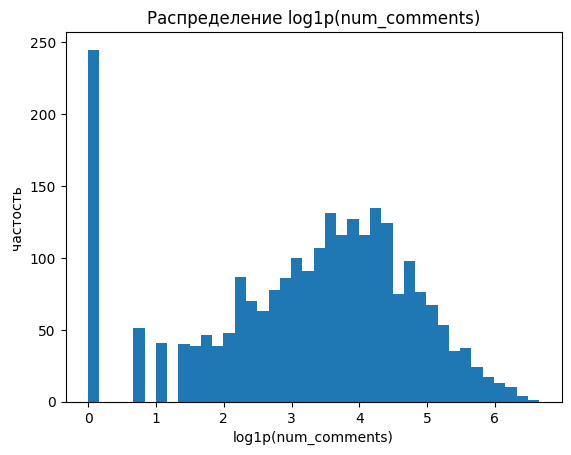

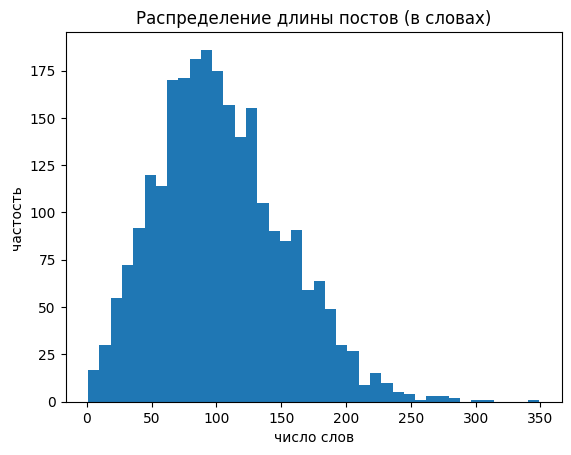

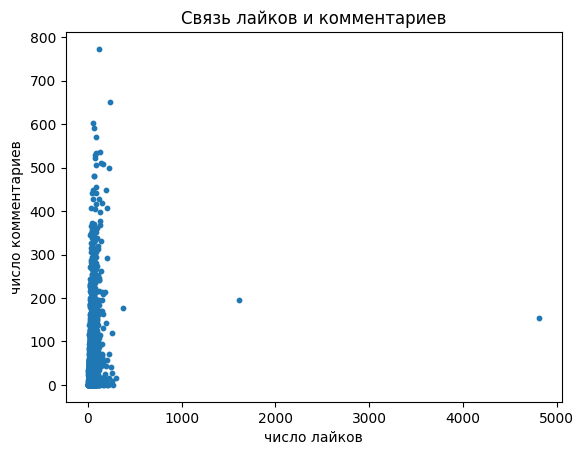

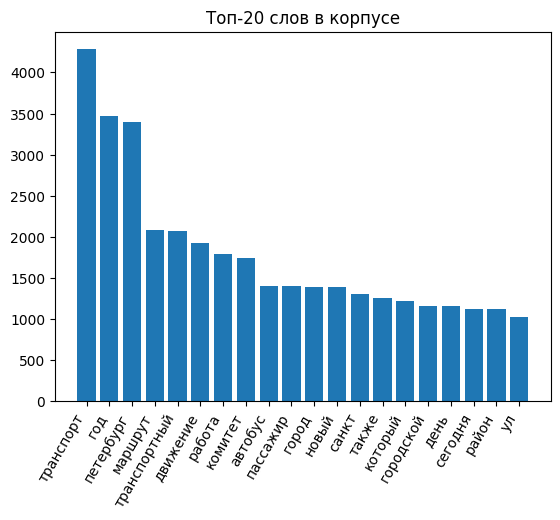

In [ ]:
plt.figure()
plt.hist(df_text["num_comments"], bins=40)
plt.title("Распределение количества комментариев")
plt.xlabel("число комментариев")
plt.ylabel("частость")
plt.show()

plt.figure()
plt.hist(np.log1p(df_text["num_comments"]), bins=40)
plt.title("Распределение log1p(num_comments)")
plt.xlabel("log1p(num_comments)")
plt.ylabel("частость")
plt.show()

plt.figure()
plt.hist(df_text["word_len"], bins=40)
plt.title("Распределение длины постов (в словах)")
plt.xlabel("число слов")
plt.ylabel("частость")
plt.show()

plt.figure()
plt.scatter(df_text["num_like"], df_text["num_comments"], s=10)
plt.title("Связь лайков и комментариев")
plt.xlabel("число лайков")
plt.ylabel("число комментариев")
plt.show()

all_words = " ".join(df_text["process_texts"].tolist()).split()
freq = pd.Series(all_words).value_counts().head(20)

plt.figure()
plt.bar(freq.index, freq.values)
plt.title("Топ-20 слов в корпусе")
plt.xticks(rotation=60, ha="right")
plt.show()

In [ ]:

y = df_text["num_comments"].astype(float).values
y_log = np.log1p(y)

X = df_text[[
    "process_texts",
    "log1p_num_like", "log1p_views", "log1p_reposts",
    "hour", "dow", "month",
    "char_len", "word_len"
]].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1992, 9) Test: (498, 9)


In [ ]:
text_col = "process_texts"
num_cols = ["log1p_num_like","log1p_views","log1p_reposts","hour","dow","month","char_len","word_len"]

preprocess = ColumnTransformer(
    transformers=[
        ("txt", TfidfVectorizer(max_features=80000, ngram_range=(1,2), min_df=2), text_col),
        ("num", Pipeline([("sc", StandardScaler(with_mean=False))]), num_cols)
    ],
    remainder="drop"
)

ridge_model = Pipeline(steps=[
    ("prep", preprocess),
    ("reg", Ridge(alpha=2.0, random_state=42))
])

ridge_model.fit(X_train, y_train)

pred_log = ridge_model.predict(X_test)
pred = np.expm1(pred_log)
y_true = np.expm1(y_test)

mae = mean_absolute_error(y_true, pred)

mse = mean_squared_error(y_true, pred)   
rmse = np.sqrt(mse)

r2 = r2_score(y_true, pred)

print("TF-IDF + Ridge")
print("MAE:", mae)
print("RMSE:", rmse)
print("R2:", r2)

TF-IDF + Ridge
MAE: 32.94825406328143
RMSE: 62.47589291670781
R2: 0.40087991382457444


In [ ]:

tfidf = ridge_model.named_steps["prep"].named_transformers_["txt"]
ridge = ridge_model.named_steps["reg"]

feature_names = tfidf.get_feature_names_out()
coef = ridge.coef_[:len(feature_names)]  

top_pos_idx = np.argsort(coef)[-20:][::-1]
top_neg_idx = np.argsort(coef)[:20]

print("ТОП-20 слов/фраз, которые увеличивают прогноз комментариев:")
for i in top_pos_idx:
    print(feature_names[i], ":", coef[i])

print("\nТОП-20 слов/фраз, которые уменьшают прогноз комментариев:")
for i in top_neg_idx:
    print(feature_names[i], ":", coef[i])

ТОП-20 слов/фраз, которые увеличивают прогноз комментариев:
район : 1.305716598054382
автобус : 1.2125414524910443
зона : 1.0248333023665184
маршрут : 0.9946295882140562
зона платный : 0.8731173263673925
нарушение : 0.8670247624343475
напомнить : 0.7639015851171087
самокат : 0.7496637502424796
сие : 0.7466911341812649
км : 0.7464074881479041
достоевский : 0.7456014549037587
карточка : 0.6725062562620815
проезд : 0.6704425207172201
направление : 0.6624129634300175
электросамокат : 0.6378824090284297
также : 0.6276332857433092
тыс : 0.6232881486173097
номер : 0.6156395768132165
перевозчик : 0.6139015576710339
улучшение : 0.6128708946629279

ТОП-20 слов/фраз, которые уменьшают прогноз комментариев:
жизнь : -1.125094338002604
присоединяться : -1.0841114569384274
ребёнок : -1.0011468988995884
хороший : -0.9887077445072202
работник : -0.9632249119973876
отправиться : -0.9329746572043314
фестиваль : -0.9067112371974325
должность : -0.9016510805602777
сотрудник : -0.9002034839885696
предприяти

In [ ]:
from sklearn.linear_model import PoissonRegressor
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

y_train_cnt = np.maximum(0, np.expm1(y_train))
y_test_cnt  = np.maximum(0, np.expm1(y_test))

preprocess_poisson = ColumnTransformer(
    transformers=[
        ("txt", TfidfVectorizer(
            max_features=40000,
            ngram_range=(1,1),
            min_df=3,
            sublinear_tf=True
        ), text_col),
        ("num", MaxAbsScaler(), num_cols)
    ],
    remainder="drop"
)

poisson_model = Pipeline(steps=[
    ("prep", preprocess_poisson),
    ("reg", PoissonRegressor(alpha=1e-2, max_iter=15000, tol=1e-6))
])

poisson_model.fit(X_train, y_train_cnt)
print("Poisson n_iter_ =", poisson_model.named_steps["reg"].n_iter_)

pred_p = poisson_model.predict(X_test)
pred_p = np.maximum(0, pred_p)

mae_p = mean_absolute_error(y_test_cnt, pred_p)
mse_p = mean_squared_error(y_test_cnt, pred_p)
rmse_p = np.sqrt(mse_p)
r2_p = r2_score(y_test_cnt, pred_p)

print("TF-IDF + PoissonRegressor")
print("MAE:", mae_p)
print("RMSE:", rmse_p)
print("R2:", r2_p)

Poisson n_iter_ = 368
TF-IDF + PoissonRegressor
MAE: 34.85262616239326
RMSE: 61.227641640275365
R2: 0.42458126275362185


In [ ]:
print("СРАВНЕНИЕ:")
print(f"Ridge  : MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
print(f"Poisson: MAE={mae_p:.3f}, RMSE={rmse_p:.3f}, R2={r2_p:.3f}")

СРАВНЕНИЕ:
Ridge  : MAE=32.948, RMSE=62.476, R2=0.401
Poisson: MAE=34.853, RMSE=61.228, R2=0.425
